In [1]:
from torchvision.models import resnet18
from torchvision import transforms
import numpy as np
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import pylab as pl
import time
import pyinn.ncrelu as ncrelu
from IPython import display

In [2]:
training_data = torch.load('/data/mini_imagenet/mIN_train.pth')
training_data += torch.load('/data/mini_imagenet/mIN_test.pth')
training_data += torch.load('/data/mini_imagenet/mIN_val.pth')
testing_data = [i[-50:] for i in training_data]
training_data = [i[:-50] for i in training_data]
print len(testing_data[0]),len(training_data[0])

50 550


In [3]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return ncrelu(self.layers(inp))

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.process = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(128,128),
            nn.MaxPool2d(2),
            Block(256,256),
            nn.MaxPool2d(2),
            Block(512,512),
            nn.MaxPool2d(2),
            Block(1024,1024),
            nn.AvgPool2d((5,5)))
        self.final = nn.Sequential(
            nn.Linear(2048,100)
        )
            
    def forward(self, inp):
        out = self.process(inp)
        return self.final(out.view(-1, 2048))


In [4]:
model = ENCODER()
model.cuda()
nweights = sum([i.numel() for i in list(model.parameters())])
print(nweights," parameters in neural net.")

(12783268, ' parameters in neural net.')


In [5]:
standardize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])
            ])

alter = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(84,padding=10),
            standardize
            ])

def batchmaker(theset, way=20, shot=1, alterful=False):
    classes = np.random.choice(len(theset),way)
    if alterful:
        li = [torch.cat([alter(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(len(theset[0]),shot)],dim=0).float()
              for cl in classes]
    else:
        li = [torch.cat([standardize(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(len(theset[0]),shot)],dim=0).float()
              for cl in classes]
    support = torch.cat([t[:shot,:,:,:] for t in li],dim=0)
    stargs = torch.LongTensor(np.repeat(classes, shot))
#     query = torch.cat([t[trainshot:,:,:,:] for t in li],dim=0)
#     qtargs = torch.LongTensor([i//shot for i in range(testshot*way)])
    return(Variable(support, volatile=(not alterful)).cuda(),
           Variable(stargs, volatile=(not alterful)).cuda()
          )
# batchmaker(training_data,shot=2)

In [6]:
criterion = nn.CrossEntropyLoss().cuda()
# optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def evaluate(model, criterion, testing_data, shot=10, way=100):
    support, targs = batchmaker(testing_data, way=way, shot=shot)
    support = support.view(50, 20, 3, 84, 84)
    targs = targs.view(50, 20)
    acc = 0
    loss = 0
    for i in range(50):
        preds = model(support[i,:,:,:,:])
        loss += criterion(preds, targs[i,:]).data[0]
        _,bins = torch.max(preds, 1)
        acc += torch.sum(torch.eq(bins,targs[i,:])).data[0]
    acc = float(acc)/shot/way
    return float(loss)/50, acc

149.077368617 0.26


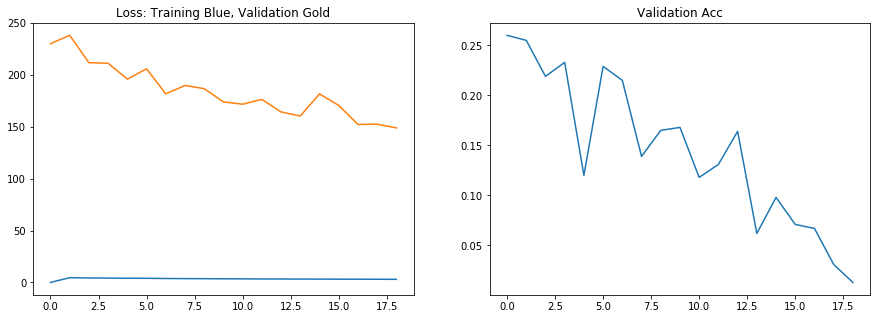

Train loss is: 3.03916015744
Validation accuracy is: 0.26
Validation loss is: 149.077368617

255.370457888
3650
3700
3750
3800


In [ ]:
%matplotlib inline

vbity = 200
epoch = 10000
start = time.time()
losstracker = []
evalacctracker = []
evallosstracker = []
runningloss = 0
for it in range(10*epoch):
    if it%50==0:
        print(it)
    
    # Build batch
    support, targs = batchmaker(training_data, alterful=True)
    
    # Predict
    model.zero_grad()
    preds = model(support)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001/(2**(it//epoch)))
    loss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == 0:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        model = model.eval()
        evalloss, evalacc = evaluate(model, criterion, testing_data)
        print evalloss, evalacc
        model = model.train()
        evallosstracker.append(evalloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
#         pl.ylim((.5,3))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
#         pl.ylim((0.3,.8))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+"\n")
        runningloss = 0
        print(time.time()-start)